In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd
from pandas.tools.plotting import scatter_matrix

import matplotlib.image as mpimg

In [17]:
def centerize( df ):
    mean = np.mean( df, axis = 0 )
    centered = df - mean 
    return (centered, mean)

class PCA:
    def __init__(self, X):
        # X's shape (items,dimensions)
        (centered, self.means) = centerize(X)
        cov = np.cov( centered.T )

        (eig_values, eig_vectors) = np.linalg.eig(cov)

        eig_idx = np.argsort(-eig_values)
        (self.eig_values, self.eig_vectors) = (eig_values[eig_idx], eig_vectors[:,eig_idx])
        
    def project(self, X):
        # X's shape (items,dimensions)
        X = X - self.means
        return np.dot(X, self.eig_vectors)
    
    def reconstruct(self, X, eig_vectors_idx):
        res = np.dot( X, self.eig_vectors[:, eig_vectors_idx].T )
        res = res.T + self.means.reshape(len(self.means),1)
        return res.T
    

# Q3.1 Preprocessing

In [18]:
dpca2 = pd.read_csv('pca2.csv', sep=",")

In [19]:
dpca2.describe()

,X1,X2
count,500.000000,500.000000
mean,0.951146,1.012466
std,1.656783,1.272475
min,-3.776304,-13.000000
25%,-0.150238,0.441767
50%,0.992120,1.029902
75%,1.997481,1.662033
max,5.964610,13.000000


In [20]:
pca2 = PCA(dpca2)

In [21]:
projectedPCA2 = pca2.project(dpca2)

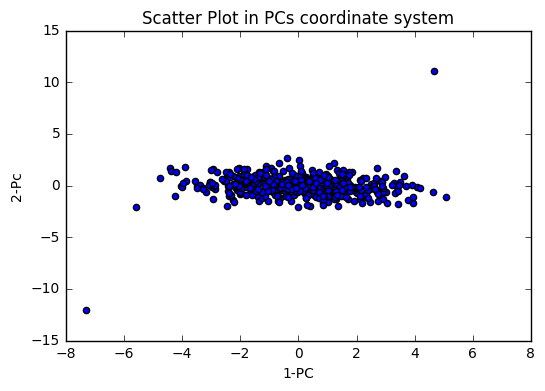

In [53]:
plt.scatter(projectedPCA2[:, 0], projectedPCA2[:, 1])
plt.ylim(-15,15)
plt.xlim(-8,8)
plt.xlabel('1-PC')
plt.ylabel('2-Pc')
plt.title('Scatter Plot in PCs coordinate system')

From the plot above, we observe 2 outliers.

In [44]:
dpca2_adjusted = np.delete(dpca2.values,[16,156],0)
dpca2_adjusted.shape

(498, 2)

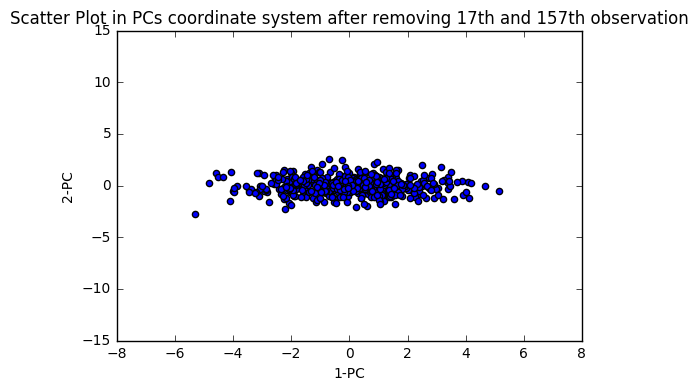

In [55]:
pca2 = PCA(dpca2_adjusted)
projectedPCA2Adjusted = pca2.project(dpca2_adjusted)
plt.scatter(projectedPCA2Adjusted[:, 0], projectedPCA2Adjusted[:, 1])
plt.xlabel('1-PC')
plt.ylabel('2-PC')
plt.ylim(-15,15)
plt.xlim(-8,8)
plt.title('Scatter Plot in PCs coordinate system after removing 17th and 157th observation')

# Q3.2 Whitening

In [56]:
dpca4 = pd.read_csv('pca4.csv', sep=",")

In [58]:
dpca4.describe()

,X1,X2,X3,X4
count,500.000000,500.000000,500.000000,500.000000
mean,0.005812,0.107921,-0.020360,-0.012750
std,1.705942,1.774020,0.817685,0.823096
min,-5.826935,-5.130027,-12.000000,-12.000000
25%,-1.227183,-0.989710,-0.222386,-0.222493
50%,0.000000,0.000000,-0.011047,-0.035263
75%,1.084526,1.361009,0.194231,0.200987
max,4.717990,5.024882,12.000000,12.000000


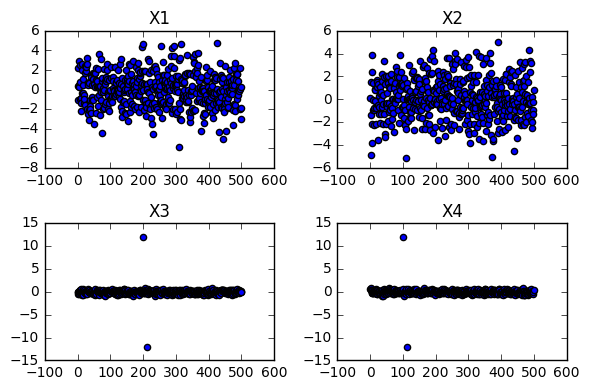

In [66]:
r = range(500)
cols = ['X1','X2','X3','X4']
for i in range(len(cols)): 
    plt.subplot(2,2,i+1)
    plt.scatter(r, dpca4[cols[i]])
    plt.title(cols[i])
plt.tight_layout()

In [72]:
pca4 = PCA(dpca4)
pca4.eig_values

array([ 4.13329173,  1.92436473,  0.67762223,  0.66820255])

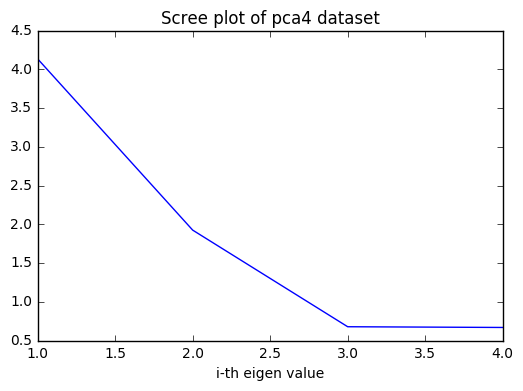

In [74]:
plt.title('Scree plot of pca4 dataset')
plt.plot( range(1,5), pca4.eig_values )
plt.xlabel('i-th eigen value')

From the plot, the first 2 PCs are sufficient to represent the data

In [95]:
def whitening(X):
    (centered, _) = centerize(X)
    pc = PCA(centered)
    A  = np.diag( np.sqrt(pc.eig_values) )
    Z = ( centered @ pc.eig_vectors ) @ A
    return Z

In [87]:
pca4_whitened = whitening(dpca4)

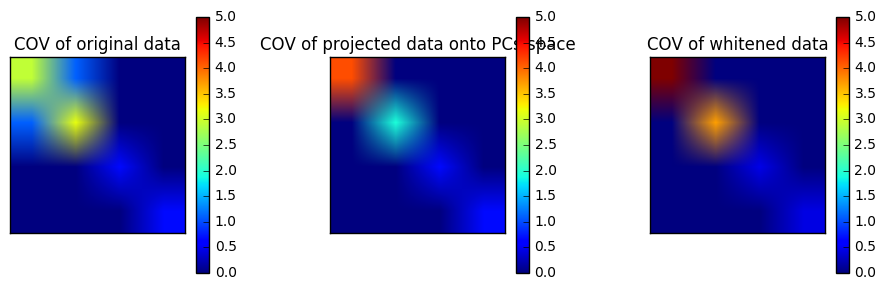

In [128]:
plt.figure(figsize=(9,3))

cov_original = np.cov(dpca4.T)
plt.subplot(1,3,1)
plt.title('COV of original data')
plt.imshow(cov_original, vmin=0, vmax=5)
plt.colorbar()
plt.xticks([])
plt.yticks([])

dpca4_projected = pca4.project(dpca4)
cov_projected = np.cov(dpca4_projected.T)
plt.subplot(1,3,2)
plt.title('COV of projected data onto PCs space')
plt.imshow(cov_projected, vmin=0, vmax=5)
plt.colorbar()
plt.xticks([])
plt.yticks([])

cov_whitened = np.cov(pca4_whitened.T)
plt.subplot(1,3,3)
plt.title('COV of whitened data')
plt.imshow(cov_whitened, vmin=0, vmax=5)
plt.colorbar()
plt.xticks([])
plt.yticks([])

plt.tight_layout()